In [1]:
import pathlib
import tensorflow as tf
from tensorflow.keras.applications import   
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint


namecheckpoint = 'TreinosTF/VGG16/v1/model.{epoch:02d}-{val_accuracy:.2f}.h5' 
model_checkpoint_callback = ModelCheckpoint(namecheckpoint,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    # change output folder
 )
data_dir = pathlib.Path("/Users/aroldogoulartbarros/workspace/faculdade/slime-ia/Dados")
 
# Define the classes from the data_dir
classes = pathlib.Path(data_dir).glob('*')
classes = [x for x in classes if x.is_dir()]
classes = sorted([x.stem for x in classes])
print(classes)

# Define batch size
batch_size = 32
img_height = 224
img_width = 224

epochs = 12
# Define the data directory

# Create training dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Create validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load the pre-trained VGG16 model
pre_trained_model = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Freeze all layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Add custom classification head
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(classes), activation='softmax')(x)


# Create the final model
model3 = Model(inputs=pre_trained_model.input, outputs=predictions)

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model using the training dataset and validation dataset
history = model3.fit(
    dataset, 
    validation_data=validation_dataset, 
    epochs=epochs,
    callbacks=[model_checkpoint_callback]  
    )
    


['manga', 'manhua', 'novels', 'webcomic']
Found 918 files belonging to 4 classes.
Using 735 files for training.
Found 918 files belonging to 4 classes.
Using 183 files for validation.
58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/12
23/23 [==============================] - ETA: 0s - loss: 18.1522 - accuracy: 0.8272

/Users/aroldogoulartbarros/miniforge3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 158s 7s/step - loss: 18.1522 - accuracy: 0.8272 - val_loss: 2.4662 - val_accuracy: 0.9508
Epoch 2/12
23/23 [==============================] - 230s 10s/step - loss: 0.9234 - accuracy: 0.9782 - val_loss: 2.7154 - val_accuracy: 0.9563
Epoch 3/12
23/23 [==============================] - 206s 9s/step - loss: 1.3744 - accuracy: 0.9850 - val_loss: 1.7567 - val_accuracy: 0.9781
Epoch 4/12
23/23 [==============================] - 174s 8s/step - loss: 0.5597 - accuracy: 0.9878 - val_loss: 2.8805 - val_accuracy: 0.9617
Epoch 5/12
23/23 [==============================] - 166s 7s/step - loss: 0.2076 - accuracy: 0.9932 - val_loss: 2.6004 - val_accuracy: 0.9781
Epoch 6/12
23/23 [==============================] - 164s 7s/step - loss: 0.0362 - accuracy: 0.9986 - val_loss: 2.6285 - val_accuracy: 0.9781
Epoch 7/12
23/23 [==============================] - 162s 7s/step - loss: 0.3463 - accuracy: 0.9918 - val_loss: 5.3943 - val_accuracy: 0.9563
Epoch 8/12
23/23 [====

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator()  # Rescale pixel values to [0, 1]
test_data_dir = "/Users/aroldogoulartbarros/workspace/faculdade/slime-ia/Testes"


# Create a test generator
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),  # Adjust the target size to match your model's input size
    batch_size=batch_size,  # Batch size for generating predictions
    class_mode='categorical',  # Change this to 'binary' i  f you have a binary classification problem
    shuffle=False  # Set to False to maintain the order of images
)

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Calculate the number of images in the dataset
num_images = len(test_generator.filenames)

# Initialize empty lists to store images and true labels
all_images = []
all_true_labels = []

# Loop through the generator to accumulate all images and true labels
for i in range(num_images // batch_size):
    images, true_labels = next(test_generator)
    all_images.append(images)
    all_true_labels.append(true_labels)

# Concatenate the accumulated images and true labels
all_images = np.concatenate(all_images)
all_true_labels = np.concatenate(all_true_labels)

# Make predictions using the model on all images
predictions = model3.predict(all_images)

# Now, you have predictions for all images in the test dataset
print("Total number of images:", len(all_images))
print(class_labels)


Found 751 images belonging to 4 classes.
23/23 [==============================] - 104s 5s/step
Total number of images: 736
['manga', 'manhua', 'novels', 'webcomic']


In [8]:
import numpy as np

predicted_labels = [class_labels[np.argmax(pred)] for pred in predictions]

# Real label
labels_true = [class_labels[np.argmax(true)] for true in true_labels]

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
true_labels = np.argmax(all_true_labels, axis=1)

# Calculate accuracy
accuracy = np.mean(np.equal(predicted_labels, true_labels))
accuracy_percentage = accuracy * 100

print("Accuracy:", accuracy_percentage, "%")



Accuracy: 97.01086956521739 %


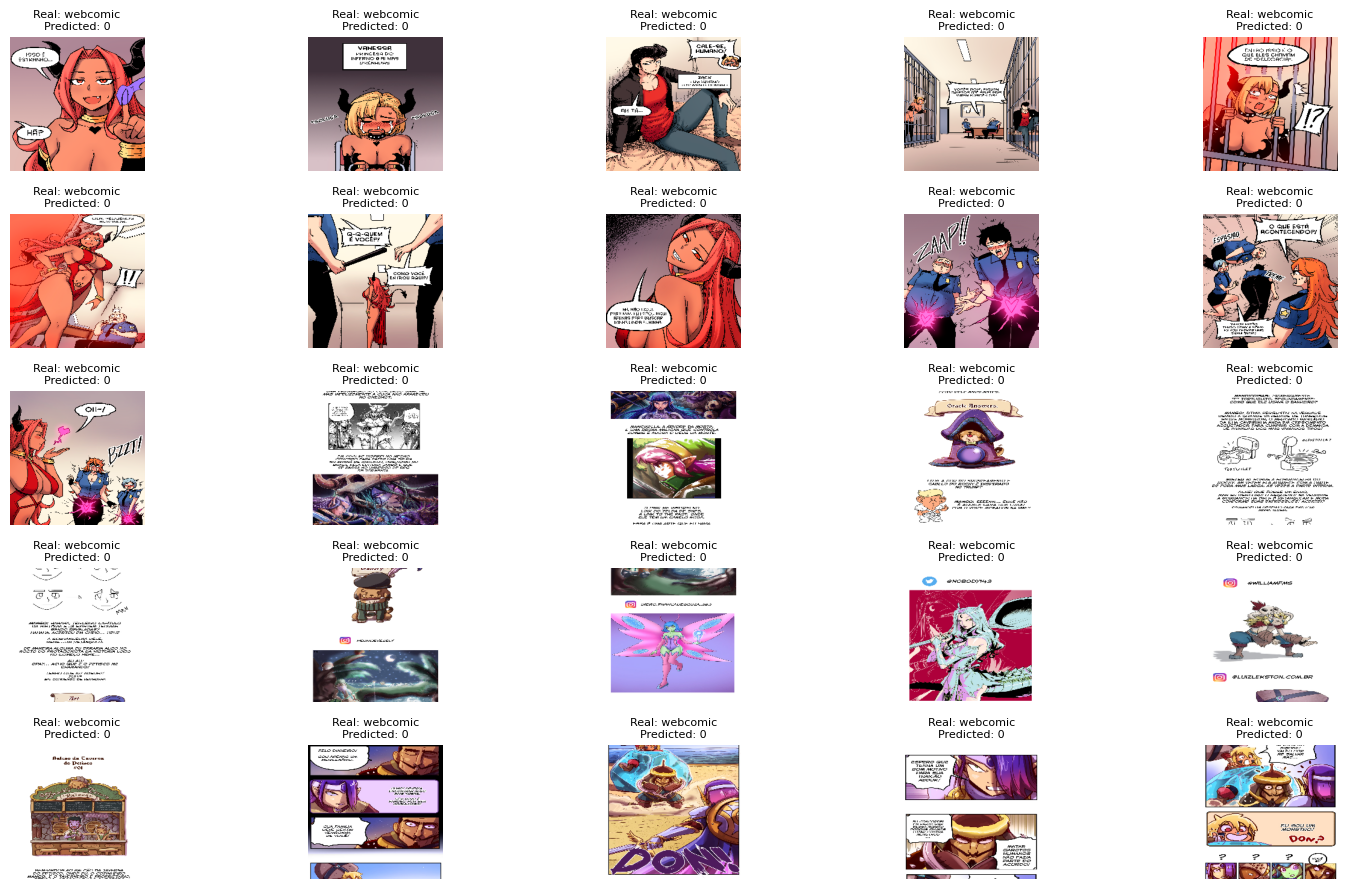

In [4]:

# Create a figure with multiple rows and columns to display images
num_rows = 5  # Number of rows of images to display
num_cols = 5  # Number of columns of images to display

# Create a figure to display the images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 9))
for i in range(num_rows * num_cols):  # Display only 25 images
    ax = axes[i // num_cols, i % num_cols]
    if images[i].dtype == np.uint8:
        ax.imshow(images[i])
    else:
        ax.imshow(images[i] / 255.0)
    ax.set_title(f'Real: {labels_true[i]}\nPredicted: {predicted_labels[i]}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()